The fully connected layer that we saw doesn’t respect the spatial structure of the input. If, for example, the input is an image, the NN will destruct the 2D structure into a 1-dimensional vector. To address the issue, we have designed Convolutional Neural Networks (CNNs). They work exceptionally well for computer vision applications.

Convolutional layers exploit the local structure of the data.

Dot product between Image x Kernel = scalar which is a measure of similarity.
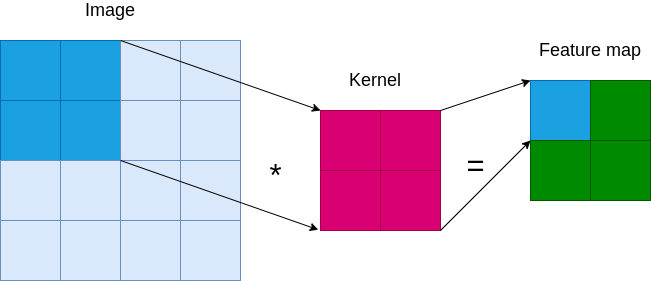!

Given an input matrix N×N and a kernel p×p, where p<N:

- We slide the filter across every possible position of the input matrix.
- At each position, we perform a dot-product operation and calculate a scalar.
- We gather all these scalar together to form the output, which is called the feature map.
  
We transformed a 2D matrix from the input space to the feature space but without losing the 2D form of the input. That way the network can capture context that only appears in parts of the image and would otherwise be lost by a fully connected layer.

- Convolution is still a linear operator.
- The weights that are in the kernel are trainable and are shared through the input.
- Each dot-product operation gives a notion of similarity.
- Convolutional layers can be performed in any number of dimensions.
- The axis that we slide the image on defines the dimension of a convolution. For images, it is a 2D convolution. But we can still apply convolutions in 1D sequences that have some kind of local structure.
  
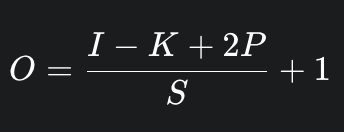
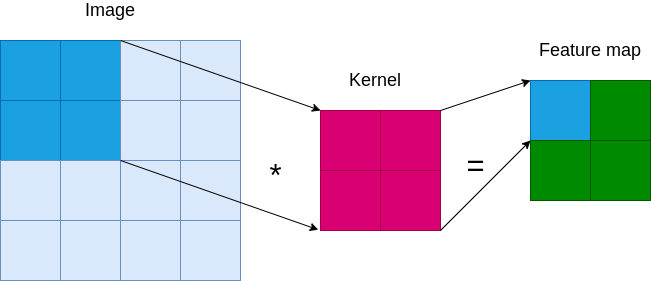
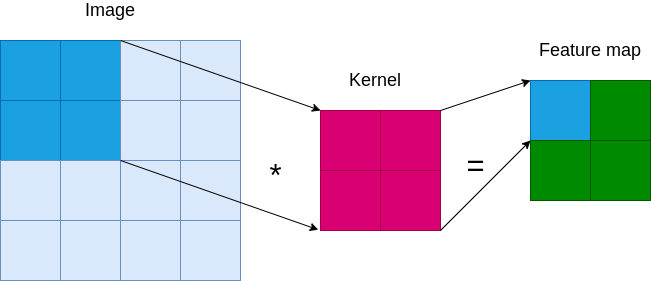
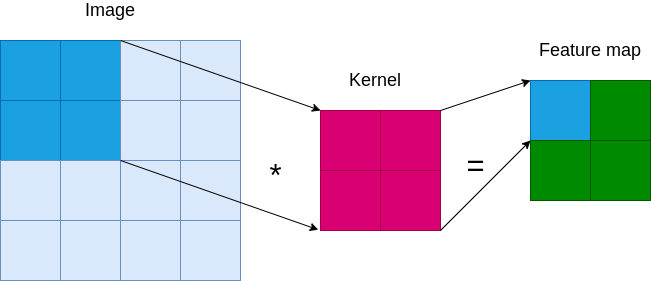

> The operation, element-wise multiply followed by a sum, is the definition of a convolution/correlation at a single location.

In [1]:
import torch

def conv2d(image, kernel):
    H, W = list(image.size())
    M, N = list(kernel.size())

    out= torch.zeros(H-M+1, W-N+1, dtype=torch.float32) # output dimensions
    for i in range(H-M+1):
        for j in range(W-N+1):
            out[i,j]= torch.sum(image[i:i+M,j:j+N]*kernel) # convolution
            # element wise multiplication then summation
            # results in a scalar for the position i,j
    return out